In [1]:
from matplotlib import colors
import matplotlib as mpl
import matplotlib.pyplot as plt
import xarray as xr
import wrf 
import cartopy
import cartopy.crs as ccrs
from metpy.plots import USCOUNTIES
import pandas as pd

mpl.rcParams['font.size'] = 14

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# To load the colormap from the JSON file and recreate it
import json
from matplotlib.colors import ListedColormap
with open('/data/keeling/a/xx24/colormap.json', 'r') as json_file:
    loaded_colors = json.load(json_file)
    loaded_colors = [(r / 255, g / 255, b / 255) for r, g, b in loaded_colors]
    cmap = ListedColormap(loaded_colors)

In [3]:
from netCDF4 import Dataset
wrfout = Dataset('/data/keeling/a/jcurtis2/d/bridges2_big_run/aerosols_d01_2010-06-17_00:00:00', "r", format="NETCDF4")
wrfinput = Dataset('/data/keeling/a/jcurtis2/d/bridges2_big_run/wrfinput_d01', "r", format="NETCDF4")
ozone = wrf.getvar(wrfout, "o3")
lats, lons = wrf.latlon_coords(ozone)
lats = wrf.to_np(lats)
lons = wrf.to_np(lons)

In [4]:
land_mask = wrfinput['LANDMASK'][0,:,:].T

In [5]:
def nc_shape(var):
    da = xr.DataArray(
        data=var.T,
        dims=["south_north", "west_east"],
        coords=dict(
            lon=(["south_north", "west_east"], lons),
            lat=(["south_north", "west_east"], lats),
        ),
        attrs=dict(
            description="var",
            units="1",
        ),
    )
    return da

In [6]:
dry_diam = 1e9 * pd.read_csv('/data/keeling/a/xx24/e/proj_mixing_state/dry_diam',sep=',',header=None)
dry_diam_small = 1e9 * pd.read_csv('/data/keeling/a/xx24/e/proj_mixing_state/dry_diam_small',sep=',',header=None)
dry_diam_large = 1e9 * pd.read_csv('/data/keeling/a/xx24/e/proj_mixing_state/dry_diam_large',sep=',',header=None)

dry_diam_1km = 1e9 * pd.read_csv('/data/keeling/a/xx24/e/proj_mixing_state/dry_diam_1km',sep=',',header=None)
dry_diam_small_1km = 1e9 * pd.read_csv('/data/keeling/a/xx24/e/proj_mixing_state/dry_diam_small_1km',sep=',',header=None)
dry_diam_large_1km = 1e9 * pd.read_csv('/data/keeling/a/xx24/e/proj_mixing_state/dry_diam_large_1km',sep=',',header=None)

In [7]:
def make_single_map(var_name,v_min, v_max, scale, cbar_label, title):

    fig, ax = plt.subplots(figsize=(5, 4), subplot_kw=dict(projection=ccrs.PlateCarree()))

    var_map = nc_shape(var_name*land_mask)
    ax.set_extent([lons.min(), lons.max(), lats.min(), lats.max()])
    ax.add_feature(USCOUNTIES.with_scale('20m'), edgecolor='grey', linewidth=0.5)
    
    states_provinces = cartopy.feature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
    
    ax.add_feature(states_provinces, edgecolor='black')
    ax.coastlines(resolution='50m', color='black', linewidth=1)
    ax.set_title(title)
    
    if scale == 'Linear':
        im = ax.pcolormesh(lons, lats, var_map[:, :], vmin=v_min, vmax=v_max, transform=ccrs.PlateCarree(), cmap=cmap)
    elif scale == 'Log':
        im = ax.pcolormesh(lons, lats, var_map[:, :], norm = colors.LogNorm(vmin=v_min, vmax=v_max),  transform=ccrs.PlateCarree(), cmap=cmap)
    else:
        print("wrong colobar scale setting")

    # Add a colorbar
    position = fig.add_axes([0.95, 0.135, 0.03, 0.735])#位置[左,下,右,上]
    cbar = plt.colorbar(im, ax=ax, cax=position)
    cbar.set_label(cbar_label)

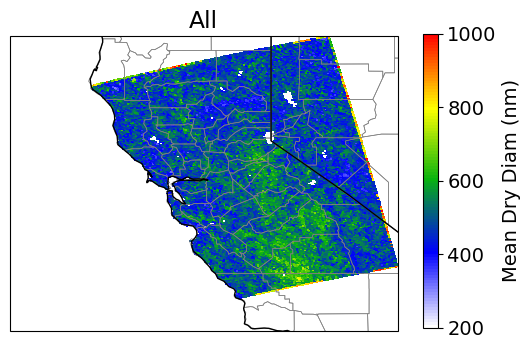

In [8]:
make_single_map(dry_diam, 200, 1000, "Linear", "Mean Dry Diam (nm)", "All")

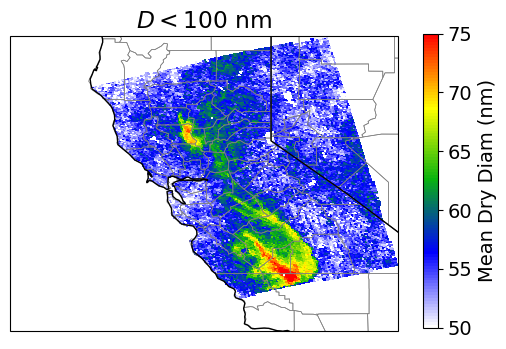

In [9]:
make_single_map(dry_diam_small, 50, 75, "Linear", "Mean Dry Diam (nm)",r'$D<100~\mathrm{nm}$')

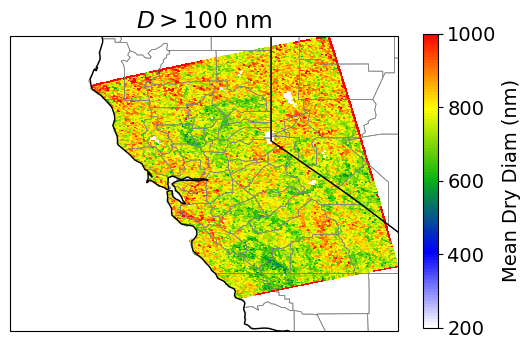

In [10]:
make_single_map(dry_diam_large, 200, 1000, "Linear", "Mean Dry Diam (nm)",r'$D>100~\mathrm{nm}$')

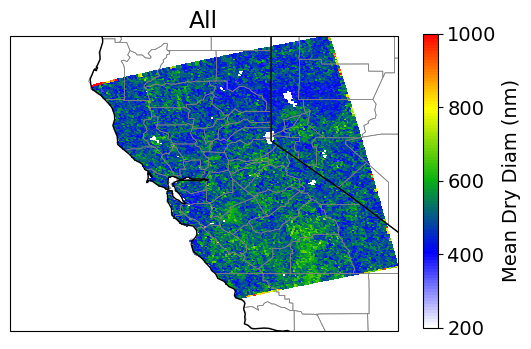

In [11]:
make_single_map(dry_diam_1km, 200, 1000, "Linear", "Mean Dry Diam (nm)", 'All')

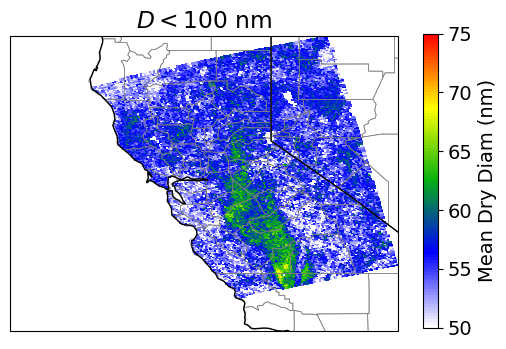

In [12]:
make_single_map(dry_diam_small_1km, 50, 75, "Linear", "Mean Dry Diam (nm)",r'$D<100~\mathrm{nm}$')

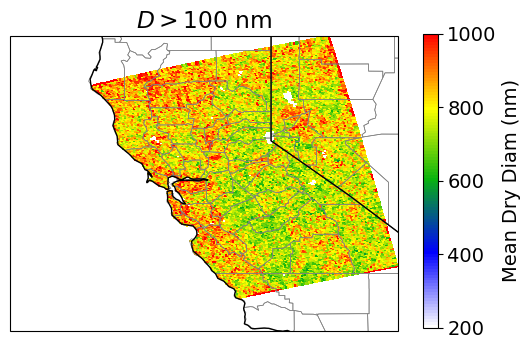

In [13]:
make_single_map(dry_diam_large_1km, 200, 1000, "Linear", "Mean Dry Diam (nm)", r'$D>100~\mathrm{nm}$')